## Trial by reducing the dimensionality of the highly correlated features

- create new features by condensing the socio-economic factors using PCA
- Try XGBoost on top of these new features (replacing the existing correponding features)

In [3]:
import pandas as pd 

df = pd.read_csv('../mount/Data_Manipulation_datasets/train.csv')

In [2]:
import numpy as np 
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder

class PrevPdayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def discretize_pdays(self, pdays):
        if pdays < 30:
            return pdays + 1
        if pdays == 999:
            return 0
        if pdays < 999:
            return 31
        if pdays > 999:
            return 32
        
    def discretize_previous(self, previous):
        if previous < 10:
            return previous
        else:
            return 10
        
    def transform(self, X):
        X['pdays'] = X['pdays'].apply(self.discretize_pdays)
        X['previous'] = X['previous'].apply(self.discretize_previous)
        return X

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

class EngineerFeatures():
    def __init__(self):
        self.num_pipeline_1 = Pipeline([
            ('prev_n_pday', PrevPdayTransformer()),
            ('log_transform', FunctionTransformer(np.log1p, validate=True)),
            ('std_scaler', StandardScaler()),
        ])
        
        self.num_pipeline_2 = Pipeline([
            ('std_scaler', StandardScaler()),
        ])
        
    def transform(self, df):
        # drop column 'default' and get the target variable 
        Y = df['y']
        X_df = df.drop(['default', 'y'], axis=1)
        
        # separate the numerical and categorical columns names 
        num_df_cols = X_df.select_dtypes(include=['int64', 'float64']).columns
        cat_df_cols = X_df.select_dtypes(include=['object']).columns
        num_pipeline_1_cols = ['duration', 'campaign', 'pdays', 'previous']
        num_pipeline_2_cols = list(set(num_df_cols) - set(num_pipeline_1_cols))
        
        # define the full pipeline
        full_pipeline_old = ColumnTransformer([
            ('num1', self.num_pipeline_1, num_pipeline_1_cols),
            ('num2', self.num_pipeline_2, num_pipeline_2_cols),
            ('one-hot-encoder', OneHotEncoder(), cat_df_cols),
        ])
        
        # Label encoding the target variable
        Y = Y.map({'no': 1, 'yes': 0})
        #X = full_pipeline_old.fit_transform(X_df)
        X = full_pipeline_old.fit_transform(X_df)
        
        #return X, Y, full_pipeline
        return X, Y, full_pipeline_old

In [68]:
def array_to_df(X, full_pipeline):
    # indices and pipelines:-
    output_indices = full_pipeline.output_indices_
    # get the columns names
    column_names = []
    for i, transformer in enumerate(full_pipeline.transformers):
        name, _, cols = transformer
        if type(cols) != list:
            column_names.extend(full_pipeline.transformers_[i][1].get_feature_names_out().tolist())
        else:
            column_names.extend(cols)
    X = pd.DataFrame(X, columns=column_names)
    return X

In [69]:
feature_engineer = EngineerFeatures()

X, Y, full_pipeline = feature_engineer.transform(df)

X_df = array_to_df(X, full_pipeline)

In [71]:
pca_columns = ["emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]     

X_df_pca = X_df[pca_columns]

In [75]:
from sklearn.decomposition import PCA   

pca = PCA(n_components=len(pca_columns))

pca.fit(X_df_pca)

PCA(n_components=5)

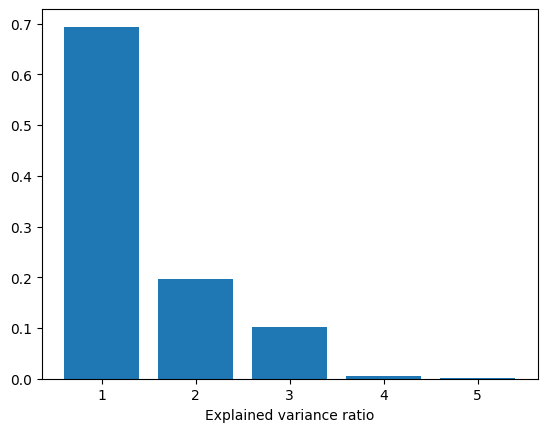

In [80]:
import matplotlib.pyplot as plt

plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel('Explained variance ratio')
plt.show()

In [79]:
pca.explained_variance_ratio_

array([0.69385648, 0.19631296, 0.10262568, 0.00506404, 0.00214084])

** Two of the three columns can be easily eliminated as they have really low explained variance ratio**

In [81]:
from sklearn.decomposition import PCA   

pca = PCA(n_components=3)

pca.fit(X_df_pca)

PCA(n_components=3)

In [84]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

class EngineerFeatures():
    def __init__(self):
        self.num_pipeline_1 = Pipeline([
            ('prev_n_pday', PrevPdayTransformer()),
            ('log_transform', FunctionTransformer(np.log1p, validate=True)),
            ('std_scaler', StandardScaler()),
        ])
        
        self.num_pipeline_2 = Pipeline([
            ('std_scaler', StandardScaler()),
        ])
        
        self.num_pipeline_pca = Pipeline([
            ('pca', PCA(n_components=3)),
            ('std_scaler', StandardScaler()),
        ])
        
    def transform(self, df):
        # drop column 'default' and get the target variable 
        Y = df['y']
        X_df = df.drop(['default', 'y'], axis=1)
        
        # separate the numerical and categorical columns names 
        num_df_cols = X_df.select_dtypes(include=['int64', 'float64']).columns
        cat_df_cols = X_df.select_dtypes(include=['object']).columns
        num_pipeline_1_cols = ['duration', 'campaign', 'pdays', 'previous']
        num_pipeline_pca_cols = ["emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]
        num_pipeline_2_cols = list(set(num_df_cols) - set(num_pipeline_1_cols) - set(num_pipeline_pca_cols))
        
        # define the full pipeline
        full_pipeline = ColumnTransformer([
            ('num1', self.num_pipeline_1, num_pipeline_1_cols),
            ('num_pca', self.num_pipeline_pca, num_pipeline_pca_cols),
            ('num2', self.num_pipeline_2, num_pipeline_2_cols),
            ('one-hot-encoder', OneHotEncoder(), cat_df_cols),
        ])
        
        # Label encoding the target variable
        Y = Y.map({'no': 1, 'yes': 0})
        X = full_pipeline.fit_transform(X_df)
        
        return X, Y, full_pipeline

In [85]:
feature_engineer = EngineerFeatures()

X, Y, full_pipeline = feature_engineer.transform(df)

# XGBoost classifier 

In [89]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier()
model.fit(X_train, Y_train)

train_score = model.score(X_train, Y_train)
val_score = model.score(X_test, Y_test)

print("Train accuracy: ", train_score)
print("Test accuracy: ", val_score)

Train accuracy:  0.9611035215543412
Test accuracy:  0.9159077109896782


In [91]:
import joblib
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import os
from sklearn.model_selection import cross_val_predict

def evaluation_metrics(Y, Y_pred, Y_prob, save_plots_dir=None):
    tp, fn, fp, tn = confusion_matrix(Y, Y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / (tp + fn + fp + tn)
    AUC = roc_auc_score(Y, Y_prob[:, 1])
    
    print("||>> Precision: ", precision)
    print("||>> Recall: ", recall)
    print("||>> F1: ", f1)
    print("||>> Accuracy: ", accuracy)
    print("||>> AUC: ", AUC)
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(Y, Y_prob[:, 1])
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve')
    if save_plots_dir:
        plt.savefig(os.path.join(save_plots_dir, 'roc_curve.png'))
    else:
        plt.show()
    
    # Precision-Recall curve
    precisions, recalls, thresholds = precision_recall_curve(Y, Y_prob[:, 0], pos_label=0)
    plt.cla()
    plt.plot(recalls, precisions)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve') 
    if save_plots_dir:
        plt.savefig(os.path.join(save_plots_dir, 'precision_recall_curve.png'))
    else:
        plt.show()
    
    AUPRC = auc(recalls, precisions)
    print("||>> AUPRC: ", AUPRC)
    
    return precision, recall, f1, accuracy, AUC, AUPRC



def save_model_and_performance(model, X, Y, model_name):
    model_dir = os.path.join('../mount/trained_models', model_name)
    os.makedirs(model_dir)
    joblib.dump(model, os.path.join(model_dir, 'model.pkl'))
    
    Y_pred = cross_val_predict(model, X, Y, cv=10)
    Y_prob = cross_val_predict(model, X, Y, cv=10, method='predict_proba')
    
    precision, recall, f1, accuracy, AUC, AUPRC = evaluation_metrics(Y, Y_pred, Y_prob, save_plots_dir=model_dir)
    with open(os.path.join(model_dir, 'metrics.txt'), 'w') as f:
        f.write("Precision: {}\n".format(precision))
        f.write("Recall: {}\n".format(recall))
        f.write("F1: {}\n".format(f1))
        f.write("Accuracy: {}\n".format(accuracy))
        f.write("AUC: {}\n".format(AUC))
        f.write("AUPRC: {}\n".format(AUPRC))

||>> Precision:  0.6375404530744336
||>> Recall:  0.5370774263904035
||>> F1:  0.583012725658479
||>> Accuracy:  0.9144505160898604
||>> AUC:  0.9464215349925178
||>> AUPRC:  0.6427071017917426


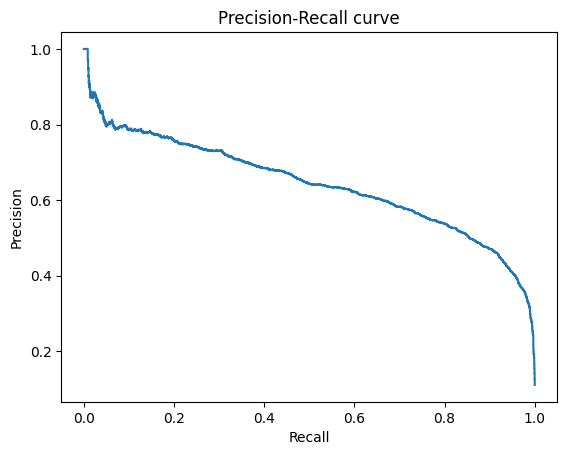

In [92]:
save_model_and_performance(model, X, Y, 'xgboost_with_pca')